# Example: PyRayHF Spherical Snell’s Law Raytracing

### Background: Snell’s Law in a Plasma

In a uniform dielectric, Snell’s law states that  

$$
n \cdot \sin(\theta) = \text{constant},
$$  

where $n$ is the refractive index and $θ$ is the propagation angle relative to the vertical.

In a plasma, however, the refractive index is not constant. It depends on:

- **Electron density** → determines the plasma frequency
- **Magnetic field strength** → splits propagation into ordinary and extraordinary modes
- **Radio frequency** of the transmitted wave
- **Angle** between the wave vector and the geomagnetic field

This results in two possible propagation modes:

- **Ordinary (O) mode**
- **Extraordinary (X) mode**

In PyRayHF, the helper functions `find_X`, `find_Y`, and `find_mu_mup` compute these indices as functions of altitude.  

Thus, the plasma-modified Snell’s law is applied as

$$
\mu \cdot \sin(\theta) = \text{constant},
$$

where $μ$ is the **phase refractive index** for the chosen wave mode.

Once the geometric path is determined, the **group delay** is evaluated by integrating along the trajectory using the **group refractive index** $μ'$.

---

### Specifics in PyRayHF (Spherical Formulation)

- Geometry (bending) uses the **phase index $μ$** in spherical geometry
- The Snell invariant is enforced as
  $$
  \mu \cdot r \cdot \sin(\theta) = \text{constant},
  $$
  where $r$ is the radial distance from the Earth’s center
- Group delay integrates the **group index $μ'$** (mup) along the curved trajectory
- The down-leg is constructed as a **mirror of the up-leg** about the turning point (apex) 
- Outputs include both spherical coordinates (central angle $ψ$, altitude $z$) and Cartesian-like coordinates $(x, z)$ for plotting convenience

---

### Notes on Visualization

- **Flat view**: x-axis = ground arc length [km], y-axis = altitude above Earth’s surface [km]



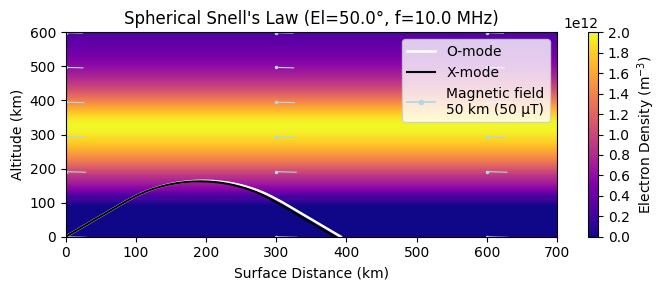

--------------------------------------------------
Spherical Snell's Law Raytracing O-mode:
--------------------------------------------------
Group Path (km):  534.7042422641736
Group delay (sec):  0.0021136070388534023
Ground Range (km):  391.9490229534571
x midpoint (km):  187.0425684888657
z midpoint (km):  164.0
x apex (km):  187.0425684888657
z apex (km):  164.0
--------------------------------------------------
Spherical Snell's Law Raytracing X-mode:
--------------------------------------------------
Group Path (km):  524.9231449845595
Group delay (sec):  0.002080809830895626
Ground Range (km):  383.3654919618976
x midpoint (km):  180.29763791933436
z midpoint (km):  162.0
x apex (km):  180.29763791933436
z apex (km):  162.0
--------------------------------------------------
Elapsed time (sec):  0.0017543990106787533
--------------------------------------------------


In [1]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from PyRayHF.library import trace_ray_spherical_snells
import time

# Directory on your local machine where to save the figures
local_dir = '/Users/vmakarevich/Documents/GitHub/PyRayHF/docs/figures/'

# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create input
# arrays using PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))

alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)

# Define inputs
elevation_deg = 50.
f0_Hz = 10e6


# Start the timer to time the code
start_time = time.perf_counter()

# Trace Using Snell's Law Spherical 2-D Raytracing O-mode
mode = "O"
result_O = trace_ray_spherical_snells(f0_Hz=f0_Hz,
                                    elevation_deg=elevation_deg,
                                    alt_km=alt_km,
                                    Ne=Ne,
                                    Babs=Babs,
                                    bpsi=bpsi,
                                    mode=mode)
# Stop the timer
end_time = time.perf_counter()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time

# Trace Using Snell's Law Spherical 2-D Raytracing X-mode
mode = "X"
result_X = trace_ray_spherical_snells(f0_Hz=f0_Hz,
                                    elevation_deg=elevation_deg,
                                    alt_km=alt_km,
                                    Ne=Ne,
                                    Babs=Babs,
                                    bpsi=bpsi,
                                    mode=mode)

# Create 2D density grid (Ne assumed horizontally uniform)
nx = 500
xmax = 1000
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
Babs_grid = np.tile(Babs[:, np.newaxis], (1, nx))
bpsi_grid = np.tile(bpsi[:, np.newaxis], (1, nx))

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_xlim(0, 700)
ax.set_ylim(0, 600)
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Surface Distance (km)')

# --- Electron density background
vmin, vmax = 0, 2e12
color_ticks = np.arange(vmin, vmax + 2e11, 2e11)
pc = ax.pcolormesh(Xg, Zg, Ne_grid, shading='auto',
                   cmap='plasma', vmin=vmin, vmax=vmax)

# --- Magnetic field visualization (simple line segments with dots)
# Babs is in Tesla (≈3–6e-5), convert to relative visual length
B_scale = 1e6  # empirical scaling factor to make lines a few tens of km long
Bx = Babs * np.sin(np.deg2rad(bpsi)) * B_scale
Bz = -Babs * np.cos(np.deg2rad(bpsi)) * B_scale

# Subsample altitudes for clarity
step_z = max(1, len(alt_km)//5)
z_sample = alt_km[::step_z]
Bx_sample = Bx[::step_z]
Bz_sample = Bz[::step_z]

# Repeat horizontally every 300 km
x_spacing = 300  # km
x_repeat = np.arange(0, ax.get_xlim()[1], x_spacing)

for x_offset in x_repeat:
    for zs, bx, bz in zip(z_sample, Bx_sample, Bz_sample):
        xs, xe = x_offset, x_offset + bx
        ze = zs + bz
        ax.plot([xs, xe], [zs, ze], color='lightblue', lw=0.8)
        ax.plot(xs, zs, 'o', color='lightblue', ms=1.5)

# --- Plot the actual ray paths
line_O, = ax.plot(result_O['x'], result_O['z'], c='white', lw=1.8, label='O-mode')
line_X, = ax.plot(result_X['x'], result_X['z'], c='black', lw=1.5, label='X-mode')

# --- Add custom magnetic field legend handle
B_ref = 50e-6  # 50 µT reference
line_length_km = B_ref * B_scale  # visible line length
legend_line = Line2D([0, 1], [0, 0], color='lightblue', lw=1.2,
                     marker='o', markersize=3,
                     label=f'Magnetic field\n{line_length_km:.0f} km (50 µT)')

# --- Labels, colorbar, legend
ax.set_title(f"Spherical Snell\'s Law (El={elevation_deg:.1f}°, f={f0_Hz/1e6} MHz)")
plt.colorbar(pc, label='Electron Density (m$^{-3}$)', ax=ax, ticks=color_ticks)

ax.legend(handles=[line_O, line_X, legend_line], loc='upper right')

plt.tight_layout()
plt.savefig(local_dir + 'Spherical_Snells.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print('--------------------------------------------------')
print('Spherical Snell\'s Law Raytracing O-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_O['group_path_km'])
print('Group delay (sec): ', result_O['group_delay_sec'])
print('Ground Range (km): ', result_O['ground_range_km'])
print('x midpoint (km): ', result_O['x_midpoint'])
print('z midpoint (km): ', result_O['z_midpoint'])
print('x apex (km): ', result_O['x_apex_km'])
print('z apex (km): ', result_O['z_apex_km'])

print('--------------------------------------------------')
print('Spherical Snell\'s Law Raytracing X-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_X['group_path_km'])
print('Group delay (sec): ', result_X['group_delay_sec'])
print('Ground Range (km): ', result_X['ground_range_km'])
print('x midpoint (km): ', result_X['x_midpoint'])
print('z midpoint (km): ', result_X['z_midpoint'])
print('x apex (km): ', result_X['x_apex_km'])
print('z apex (km): ', result_X['z_apex_km'])

print('--------------------------------------------------')
print('Elapsed time (sec): ', elapsed_time)
print('--------------------------------------------------')